## Analyse our simulation


The following code showcase a simulation for the idea of probablistic measurement for fish size with computer vision

In [57]:
import numpy as np
from numpy import random
from einops import rearrange
from matplotlib import pyplot as plt

## Preperation

In [58]:
# function for helping to calculate the corrsponding length and size of fish given average length and size of fish in image
def gimmi_a_fish_angled(theta, z_translate, scale):
    fish_vertices = np.array([[-8.5, 0, 0], [-2.5, 4, 0], [-2.5, -4, 0],  [6.5, 0, 0], [8.5,3,0], [8.5, -3, 0]], dtype=float)
    # scaling
    fish_vertices *= scale

    # rotation
    c = np.cos(theta)
    s = np.sin(theta)
    rotation = np.array([[c, 0, -s],[0, 1, 0], [s, 0, c]])
    fish_vertices = rearrange(fish_vertices, 'a b -> b a')
    fish_vertices = rotation@fish_vertices
    fish_vertices = rearrange(fish_vertices, 'a b -> b a')

    # translation
    translation = np.array([150, 150, z_translate])
    translation = np.tile(translation,(len(fish_vertices),1))
    fish_vertices = fish_vertices + translation
    return fish_vertices

# calculate area of fish in image frame
def get_area(vertices):
    x_coord = vertices[:,0]
    y_coord = vertices[:,1]
    x_shifted = np.roll(x_coord, -1)
    y_shifted = np.roll(y_coord, -1)
    a = np.inner(x_coord, y_shifted)
    b = np.inner(x_shifted, y_coord)
    return abs((0.5)*(a-b))

# return the length of fish in image frame
def get_length(vertices):
    tail = (vertices[4,:] + vertices[5,:]) / 2
    head = vertices[0,:]
    return ((head[0] - tail[0])**2 + (head[1] - tail[1])**2)**0.5



In [59]:
# We have our gimmi_many_fish() function needed for simulation here
def gimmi_a_fish(mean_scale = 1):
    fish_vertices = np.array([[0, 0, 0], [6, 4, 0], [6, -4, 0],  [15, 0, 0], [17,3,0], [17, -3, 0]], dtype=float)
    fish_faces = np.array([[0, 2, 1], [1, 3, 2], [3, 5, 4], [0, 1, 2], [1, 2, 3], [3, 4, 5]])

    # now we randomly scale and rotate (about the y axis) the fish
    # random variables
    scale = random.normal()*0.5 + mean_scale   #normal distribution 
    theta = 2*np.pi*random.rand()
    
    # scaling
    fish_vertices *= scale

    # rotation
    c = np.cos(theta)
    s = np.sin(theta)
    rotation = np.array([[c, 0, -s],[0, 1, 0], [s, 0, c]])
    fish_vertices = rearrange(fish_vertices, 'a b -> b a')
    fish_vertices = rotation@fish_vertices
    fish_vertices = rearrange(fish_vertices, 'a b -> b a')

    # translation (in a 3m x 3m x 3m tank)
    translation = random.rand(3)*300
    translation = np.tile(translation,(len(fish_vertices),1))
    fish_vertices = fish_vertices + translation
    return fish_vertices, fish_faces

def gimmi_many_fish(numb, mean_scale = 1):
    a, b = gimmi_a_fish(mean_scale)
    for i in range(numb-1):
        vertices, faces = gimmi_a_fish(mean_scale)
        faces = faces + 6*(i+1)
        a = np.vstack((a, vertices))
        b = np.vstack((b, faces))
    return a, b

## Main Function

In [61]:

def main(SCALE, trial):
    # First, note volume of the field of view:
    S1 = 1.08*1.92/(3.5/20)**2
    S2 = 1.08*1.92/(3.5/320)**2
    h = 300
    V = (S1 + S2 + (S1*S2)**0.5)*(h/3)
    # We then calculate the probability weight for each 30cm interval in fov depth
    weight = []
    for i in range(10):
        s1 = 1.08*1.92/(3.5/(30*i+20))**2
        s2 = 1.08*1.92/(3.5/(30*i+20))**2
        h = 30
        little_v = (s1 + s2 + (s1*s2)**0.5)*(h/3)
        weight += [little_v / (V*10)]*10

    # # Thus, we get the following expected distance using expected value integral
    # E_distance = (1/V) * (1.08*1.92)/(3.5*3.5) * 0.25 * (320**4 - 20**3) # Calculation of expected value integral
    # E_distance -= 20 # convert it to coordinate in global frame
    # Also, we note our projection matrix
    extrinsic = np.array([[1, 0, 0, -150], [0, 1, 0, -150], [0, 0, 1, 20]])
    intrinsic = np.array([[3.5, 0, 0], [0, 3.5, 0], [0, 0, 1]])
    projection = intrinsic@extrinsic
    projection_t = rearrange(projection, 'a b -> b a')

    # We now have to make a list (or dictionary) of: scale of fish vs average projected size at expected distance across 360 degree of rotation
    # for each scale, we rotate the fish 360 degree at different distances, then record the result 
    # we do this since it is challenging to calculate the expected size and shape in closed form, this is left as future work of the algorithm I'm designing

    expected_size = []
    expected_length = []
    scales = np.arange(0.5, 1.6, 0.1)

    for scale in scales:
        all_area = []
        all_length = []
        
        for j in range(10):     # along depth
            distance = j*30
            for i in range(10):
                theta = 2*np.pi*(i*36 / 360)       # rotating fish from 0 to 360 degree
                vertices = gimmi_a_fish_angled(theta, distance, scale)
                # project it onto the frame
                temp = np.ones((len(vertices), 1))
                vertices = np.hstack((vertices, temp))
                projected = vertices@projection_t
                projected[:,0] = np.divide(projected[:,0], projected[:,2])
                projected[:,1] = np.divide(projected[:,1], projected[:,2])

                # Now we calculate the observations
                temp = 0
                temp += get_area(projected[0:3,:])
                temp += get_area(projected[1:4,:])
                temp += get_area(projected[3:6,:])
                all_area.append(temp)
                all_length.append(get_length(projected)) 

        expected_size.append(np.inner(all_area, weight))        
        expected_length.append(np.inner(all_length, weight))
    ########################################3


    lengths = []
    sizes = []
    for _ in range(trial):
        a, _ = gimmi_many_fish(100, SCALE)
        # projecting fishes into image frame:
        temp = np.ones((len(a), 1))
        a = np.hstack((a, temp))
        projected = a@projection_t
        projected[:,0] = np.divide(projected[:,0], projected[:,2])    # divide by homogenous coordinate
        projected[:,1] = np.divide(projected[:,1], projected[:,2])
        projected[:,2] = 1

        # trim "fishes" that are not entirely within the iamge frame
        im_vertices = projected[:,0:2]
        in_frame_vertices = []
        for i in range(int(len(im_vertices) / 6)):
            coords = im_vertices[6*i:6*i+6, :]
            x_coords = coords[:, 0]
            y_coords = coords[:, 1]
            x_check = np.max(np.absolute(x_coords))
            y_check = np.max(np.absolute(y_coords))
            if x_check < 0.96 and y_check < 0.54:
                in_frame_vertices.append(coords)

        in_frame_vertices = np.array(in_frame_vertices)

        # calculate area and length of each fish, then take average
        num_fish = len(in_frame_vertices)
        total_size = 0
        total_length = 0
        for vertices in in_frame_vertices:
            total_size += get_area(vertices[0:3,:])
            total_size += get_area(vertices[1:4,:])
            total_size += get_area(vertices[3:6,:])
            total_length += get_length(vertices)

        if num_fish != 0:
            average_size = total_size/num_fish
            average_length = total_length/num_fish
            lengths.append(average_length)
            sizes.append(average_size)
        elif num_fish == 0:
            pass
    
    # Lookup index for closest observed length and estimated length, as well as size
    observed_length = np.average(lengths)
    observed_size = np.average(sizes)
  
    length_idx = (np.abs(expected_length - observed_length)).argmin()
    size_idx = (np.abs(expected_size - observed_size)).argmin()
    length_scale = scales[length_idx]
    size_scale = scales[size_idx]
    
    # Which gives the following estimated fish size:
    fish_vertices = np.array([[-8.5, 0, 0], [-2.5, 4, 0], [-2.5, -4, 0],  [6.5, 0, 0], [8.5,3,0], [8.5, -3, 0]], dtype=float)
    fish_vertices_l = fish_vertices*length_scale
    length_guess = get_length(fish_vertices_l)
    fish_vertices_s = fish_vertices*size_scale
    size_guess = get_area(fish_vertices_s[0:3,:]) + get_area(fish_vertices_s[1:4,:]) + get_area(fish_vertices_s[3:6,:])
    
    # meanwhile, the actual size and length are:
    fish_vertices_actual = fish_vertices * SCALE
    length_actual = get_length(fish_vertices_actual)
    size_actual = get_area(fish_vertices_actual[0:3,:]) + get_area(fish_vertices_actual[1:4,:]) + get_area(fish_vertices_actual[3:6,:])

    return length_guess, size_guess, length_actual, size_actual

## Visualisation

In [89]:
# We compare 
scales = np.arange(0.5, 1.5, 0.01)
a = []
b = []
c = []
d = []

for s in scales:
    length_guess, size_guess, length_actual, size_actual = main(s, 100)
    a.append(length_guess)
    b.append(size_guess)
    c.append(length_actual)
    d.append(size_actual)


/tmp/ipykernel_9584/3385402179.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


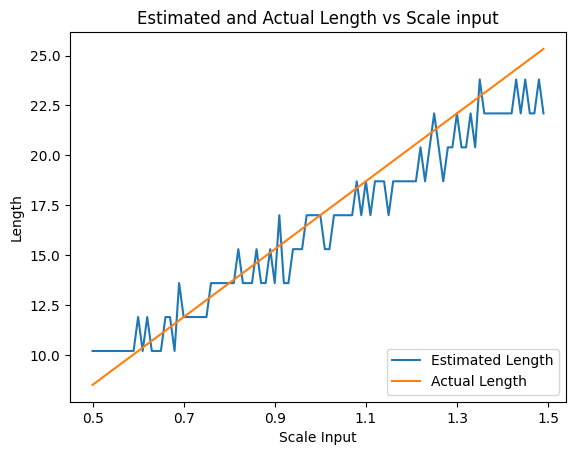

In [81]:
# Plotting estimated and actual length vs scale input
fig, ax = plt.subplots()
fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 0.5
labels[2] = 0.7
labels[3] = 0.9
labels[4] = 1.1
labels[5] = 1.3
labels += [1.5]
ax.set_xticklabels(labels)

plt.plot(a, label='Estimated Length') 
plt.plot(c, label='Actual Length')    
plt.xlabel('Scale Input')  
plt.ylabel('Length')  
plt.title('Estimated and Actual Length vs Scale input') 
plt.legend(loc='lower right')
plt.show()


/tmp/ipykernel_9584/389517468.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


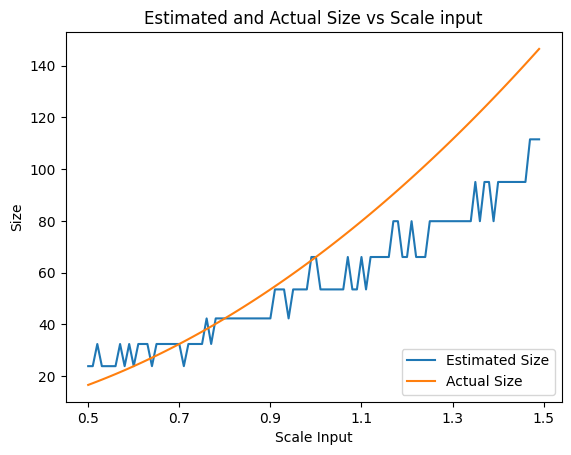

In [90]:
# Plotting estimated and actual size vs scale input
fig, ax = plt.subplots()
fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 0.5
labels[2] = 0.7
labels[3] = 0.9
labels[4] = 1.1
labels[5] = 1.3
labels += [1.5]
ax.set_xticklabels(labels)

plt.plot(b, label='Estimated Size')
plt.plot(d, label='Actual Size')   
plt.xlabel('Scale Input')
plt.ylabel('Size')
plt.title('Estimated and Actual Size vs Scale input')
plt.legend(loc='lower right')
plt.show()

In [83]:
# Comparing estimation vs number of images
a = []
b = []
c = []
d = []

for i in range(100):
    length_guess, size_guess, length_actual, size_actual = main(1, i)
    a.append(length_guess)
    b.append(size_guess)
    c.append(length_actual)
    d.append(size_actual)

/home/ansonhon/anaconda3/envs/fish_cv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/ansonhon/anaconda3/envs/fish_cv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


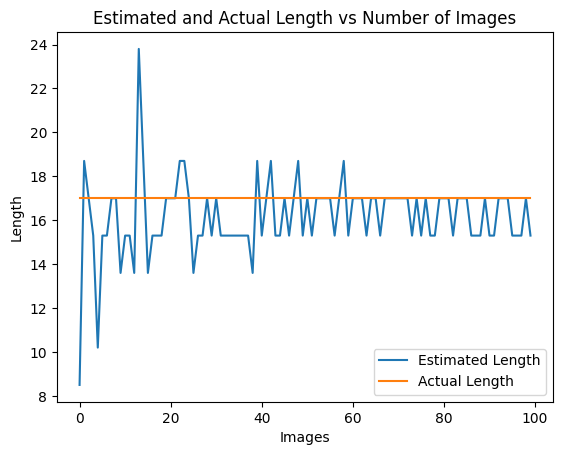

In [86]:
# Plotting the estimated and actual length vs number of images
fig, ax = plt.subplots()
fig.canvas.draw()

plt.plot(a, label='Estimated Length') 
plt.plot(c, label='Actual Length')    
plt.xlabel('Images')  
plt.ylabel('Length')  
plt.title('Estimated and Actual Length vs Number of Images') 
plt.legend(loc='lower right')
plt.show()

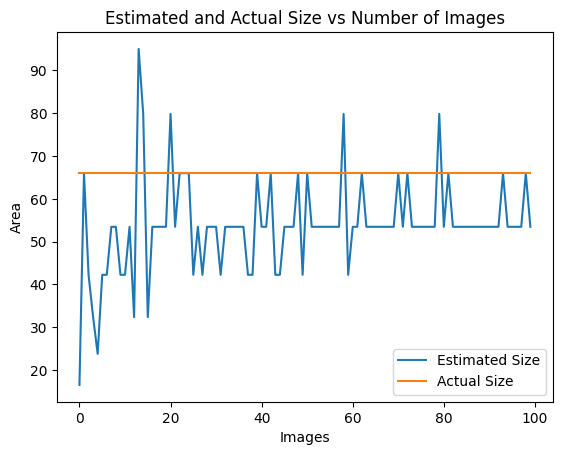

In [88]:
# Plotting the estimated and actual size vs number of images
fig, ax = plt.subplots()
fig.canvas.draw()

plt.plot(b, label='Estimated Size') 
plt.plot(d, label='Actual Size')    
plt.xlabel('Images')  
plt.ylabel('Area')  
plt.title('Estimated and Actual Size vs Number of Images') 
plt.legend(loc='lower right')
plt.show()